<a href="https://colab.research.google.com/github/DDoeuiGongju/DoItDeeplearning/blob/main/06_%EB%8B%A4%EC%B8%B5_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 벡터화(Vectorization)
> 넘파이, 머신러니, 딥러닝 패키지들은 다차원 배열의 연산 즉, 행렬 연산을 빠르게 수행할 수 있다. 이런 기능을 벡터화 연산이라고 한다. 이 연산을 이용하면 알고리즘의 성능을 높일 수 있다.  
배치 경사 하강법 연산을 이용해 벡터화된 연산을 사용할 수 있다.
- 확률적 경사 하강법: 가중치를 한 번 업데이트할 때 1개의 샘플 사용해 전역 최솟값을 불안정하게 찾는다.
- 배치 경사 하강법: 가중치를 한 번 업데이트할 때 전체 샘플 사용해 전역 최솟값을 안정적으로 찾는다. 그러나 계산 비용이 많이 든다.


### 벡터연산과 행렬 연산
> 스칼라 곱과 행렬 곱셈  
- SingleLayer클래스의 forpass() 
```
z = np.sum(x * self.w) + self.b
```
    - 위에서 입력과 가중치의 곱을 간단히 표현할 수 있는 이유는 numpy의 원소별 곱셈 기능 덕분이다.  
    - x와 w는 벡터이고, 두 벡터를 곱하여 합하는 계산을 점 곱(dot product), 스칼라 곱(scalar product)이라고 부른다.
- 점 곱을 행렬 곱셈으로 표현하면 행방향 벡터와 열 방향 벡터의 원소를 각각 곱한 후  모두 더하는 것과 같다.
```
z = np.dot(x, self.w) + self.b
```
이 행렬의 곱셈 원리를 훈련데이터 잔체 샘플에 적용해 배치 경사 하강법을 구현할 수 있다.
 



## SingleLayer클래스에 배치 경사 하강법 적용하기

In [2]:
# 위스콘신 유방암 데이터 사용
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_teat = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print('훈련 셋 크기: {}    검증 셋 크기: {}'.format(x_train.shape, x_val.shape))

훈련 셋 크기: (364, 30)    검증 셋 크기: (91, 30)


In [41]:
# 정방향 계산을 행렬 곱으로 표현: 훈련셋과 가중치를 곱한 후 절편을 더한다.
# 가중치 업데이트를 위한 gradient계산: 입력데이터(전치)와 오차의 곱

# forpass(), backprop()에 배치 결사 하강법 적용하기
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):  
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []  
        self.w_history = []      
        self.lr = learning_rate 
        self.l1 = l1   
        self.l2 = l2

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b   # np.sum대신 행렬 곱을 해주는 np.dot함수 사용 
        return z

    def activation(self, z):     
        a = 1 / (1 + np.exp(-z))   
        return a

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m   # 가중치에 대한 평균 gradient계산
        b_grad = np.sum(err) / m        # 절편에 대한 평균 gradient계산
        return w_grad, b_grad

    # 배치 경사 하강법에서는 forpass(), backprop()에서 전체 샘플을 함번에 계산하므로 for문 한 개 사용
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): 
        y = y.reshape(-1, 1)           # 타깃을 열벡터로 바꾼다.
        y_val = y_val.reshape(-1, 1)   # 검증용 타깃을 열벡터로 바꾼다.
        m = len(x)                     # 샘플 개수 저장
        self.w = np.ones((x.shape[1], 1))                        
        self.b = 0
        self.w_history.append(self.w.copy())                                                                                
        for i in range(epochs):      
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop(x, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  
            self.w -= w_grad * self.lr 
            self.b -= b_grad * self.lr
            self.w_history.append(self.w.copy()) 
            a = np.clip(a, 1e-10, 1-1e-10)                    
            # 평균 손실을 구하기 위해 각 샘플의 손실을 더한 후 전체 샘플의 개수로 나눔
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)    
            self.update_val_loss(x_val, y_val)                         

    def update_val_loss(self, x_val, y_val):             
        # for문 필요 X     
        z = self.forpass(x_val)              
        a = self.activation(z)                                 
        a = np.clip(a, 1e-10, 1-1e-10)                 
        # 평균 손실을 구하기 위해 각 샘플의 손실을 더한 후 전체 샘플의 개수로 나눔               
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
    
    def reg_loss(self): 
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    def predict(self, x):            
        z = self.forpass(x)   # 정방향 계산 수행(한번에 가능)
        return z > 0                 
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))   # 예측과 타깃의 열벡터 비교

In [4]:
# 훈련데이터 표준화 전처리하기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 전처리 데이터를 SingleLayer클래스 객체에 전달해 배치 경사 하강법 적용
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
print('성능:',single_layer.score(x_val_scaled, y_val))

성능: 0.978021978021978


훈련 셋의 샘플 수가 364개 이고, 100에폭 일 때
- 확률적 경사 하강법: 36,400번의 가중치 업데이트
- 배치 경사 하강법: 100번 업데이트

따라서, 배치 경사 하강법은 확률적 경사 하강법보다 에폭 횟수를 늘려줘야 한다.

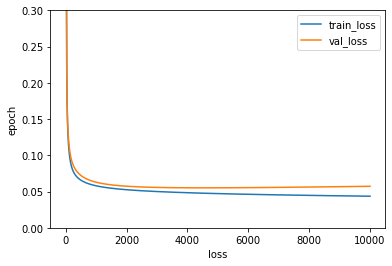

In [5]:
# 검증 셋으로 선능 측정하고 그래프로 비교
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

출력된 검증 셋의 점수는 05장과 동일하나 손실값이 안정적으로 감소  
- 05장의 손실값 변화

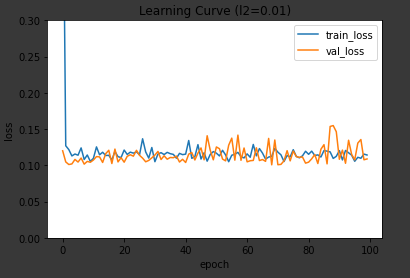


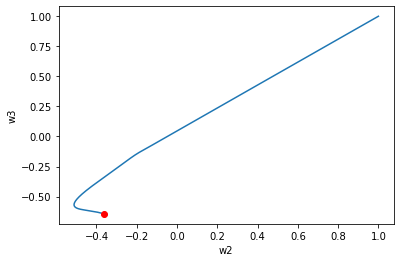

In [6]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w2')
plt.ylabel('w3')
plt.show()

가중치의 변화가 연속적이어서 손실값도 안정적으로 수렴한다. 하지만 매번 전체 훈련셋을 사용해 연산비용이 많이 들고 최솟값에 수렴하는데 시간이 많이 걸린다.

### 하나의 층에 여러 개의 뉴런
> 입력층에서 전달되는 특성이 각 뉴런에 모두 전달된다. 뉴런의 수만큼 출력이 나온다.
- 가중치 행렬의 크기는 (입력 개수x출력 개수(뉴런의 수)이다.
- XW1 + b1 = Z1  (W1: 첫번째 층의 가중치 행렬, b1: 절편. 일차원 배열)
### 출력을 하나로
> 이진 분류 문제는 각 뉴런에서 출력된 값을 하나의 뉴런으로 다시 모아야 한다. 앞서 나온 출력값을 활성화 함수에 통과시킨 활성화 출력을  마지막 뉴런에 입력해 하나의 출력을 낸다.
- A1W2 + b2 =Z2


이렇게 2개의 뉴런과 2개의 층을 가진 신경망이 만들어졌다. 입력값이 모여있는 입력층은 층의 개수에 포함하지 않는다.입력층의 값들은 은닉층을 통과한 후 출력층을 통과해 하나의 값으로 출력된다.

### 다층 신경망
> n개의 입력이 m개의 뉴런으로 입력되고, 은닉층을 통과한 값들은 다시 출력층으로 모인다. 이것이 바로 딥러닝이다.
- 주의사항  
    1) 활성화 함수는 층마다 다를 수 있지만 같은 층에서는 같아야 한다.  
    2) 모든 뉴런이 연결되어 있으면 '완전 연결 신경망(fully-connected network)'이라고 한다.  
    - 완전 연결 신경망을 모든 뉴런이 연결되어 있으므로 데이터의 입력이 고정되어 있어야 한다.
- 경사하강법 적용: W2와 b2 그리고 W1과 b1에 대한 손실함수L의 도함수를 구해야 한다. 이거에 대해 수식이 있기는 한디 아리송송송해~!
    1. 출력층: 가중치에 대해 손실함수를 미분
    2. 출력층: 도함수를 곱함
    3. 출력층: 정편에 대해 손실함수를 마분
    4. 은닉층: 가중치에 대해 손실함수를 미분
    5. 은닉층: 도함수를 곱함
    6. 절편에 대해 손실함수를 미분하고 도함수를 곱함

## 2개의 층을 가진 신경망 구현하기
- SingleLayer클래스를 상속하여 DualLayer클래스를 만들고 필요한 메서드만 재정의

In [46]:
class DualLayer(SingleLayer):
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력: 역방향 계산에 필요
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 loss 하이퍼파라미터
        self.l2 = l2               # L2 loss 하이퍼파라미터
        # 가중치 변화 기록 X
    
    def forpass(self, x):                          # 은닉층과 출력층의 정방향 계산
        z1 = np.dot(x, self.w1) + self.b1         # 첫 번째 층의 선형식 계산
        self.a1 = self.activation(z1)             # 활성화 함수 적용
        z2 = np.dot(self.a1, self.w2) + self.b2   # 두 번째 층의 선형식 계산
        return z2
    
    def backprop(self, x, err):
        m = len(x)   # 샘플 개수
        # 출력층의 가중치, 절편에 대한 gradient의 평균 계산
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 은닉층의 gradient를 쉽게 구하기 위해 시그모이드 함수 gradient계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치, 절편에 대한 gradient의 평균 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    # fit()메서드를 3개로 분리
    # 가중치, 절편 초기화: 이에 따라 학습률, 학습 속도가 달라짐
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))   # (특성 개수, 은닉층 뉴런의 개수(크기))
        self.b1 = np.zeros(self.units)                # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))            # (은닉층의 크기, 1)
        self.b2 = 0
    
    # 2. 에폭마다 정방향 계산해 오차 계산하고 오차를 역전파해 가중치와 절편의 gradient계산
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)            # 타깃을 열벡터로
        y_val = y_val.reshape(-1, 1)
        m = len(x)                      # 샘플 수 저장
        self.init_weights(x.shape[1])   # 은닉층과 출력층의 가중치, 절편 초기화
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실값과 규제 손실값 더해 리스트에 추가
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 셋에 대한 손실 계산
            self.update_val_loss(x_val, y_val)

    def training(self, x, y, m):   # 정방향 계산과 gradient 업데이트
        z = self.forpass(x)        # 정방향 계산
        a = self.activation(z)     # 활성화 함수 적용
        err = -(y - a)             # 오차 계산
        # 오차를 역전파해 gradient계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # gradient에서 패널티항의 미분값을 뺌
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def reg_loss(self): 
        # 은닉층과 출력층의 가중치에 대한 L1loss, L2loss 계산
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [47]:
# 다층 신경망 모델 훈련하고 평가하기
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
print('성능:', dual_layer.score(x_val_scaled, y_val))

성능: 0.978021978021978


해결하려는 문제가 간단하고 데이터셋의 크기가 작으므로 평가 점수가 단일 신경망과 비슷하다.

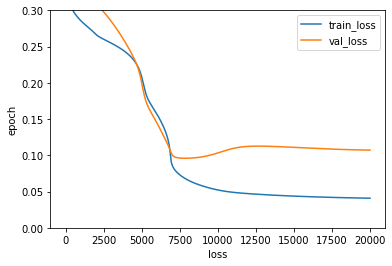

In [48]:
# 훈련 손실과 검증 손실 그래프 분석하기
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

- 훈련 손실 그래프: 훈련데이터로 손실 함수의 최솟값을 찾아가는 과정을 보여줌
- 검증 손실 그래프: 검증데이터로 손실 함수의 최솟값을 찾아가는 과정을 보여줌  


SingleLayer보다 가중치의 개수가 많아져 학습하는데 시간이 오래 걸리므로 손실그래프가 천천히 감소한다.  

위스콘신 유방암 데이터의 특성은 30개이므로 SingleLayer를 사용했을 떄는 가중치 30개와 절편 1개가 필요했다. DualLayer는 은닉층은 뉴런이 10개 이므로 30X10개의 가중치와 10개의 절편이 필요하고 출력층은 10개의 가중치와 1개의 절편이 필요하다. 즉, 321개의 가중치를 학습해야한다.  

손실 함수가 감소하는 방향을 찾는 데 오래 걸려 초기 손실값 감소가 매끄럽지 않다. 이는 가중치 초기화와 관련이 깊다. 여태까지는 초깃 값을 1로 지정했으나 random.nomal()함수를 사용해 초기화해 볼 것이다.
- random.nomal(평균, 표준 편차, 배열 크기)

In [49]:
class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features):
        np.random.seed(42)   # 균일한 출력값을 얻기 위해 랜덤값의 초깃값 고정
        self.w1 = np.random.normal(0, 1, (n_features, self.units))   # (특성 개수, 은닉층 크기)
        self.b1 = np.zeros(self.units)                               # 은닉층 크기
        self.w2 = np.random.normal(0, 1, (self.units, 1))            # (은닉층 크기, 1)
        self.b2 = 0

성능: 0.978021978021978


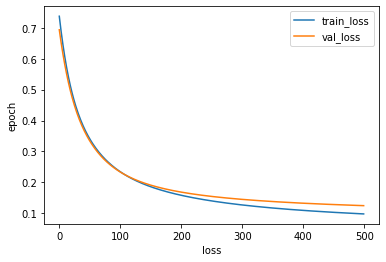

In [59]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print('성능:', random_init_net.score(x_val_scaled, y_val))
# 훈련 손실과 검증 손실 그래프 분석하기
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

손실함수의 감소가 매끄럽고 빠르게 손실함수 값이 줄어든다. 그러나 훈련하는데 많은 시간이 소요된다. 

## 미니 배치 경사 하강법
> 배치 경사 하강법과 유사하지만 에폭마다 전체 데이터를 사용하지 않고 제곱수 크기(16,32,64..)로 나눈 미니 배치만틈 정방향 계산을 수행하고 gradient를 구해 가중치를 업데이트 한다.
- 미니 배치 크기가 1이면 확률적 경사 하강법, 전체 데이터 크기면 배치 경사 하강법
- 미니 배치의 최적값은 정해진 것이 아니고 하이퍼파라미터이며 튜닝의 대상


-  generator: 순차적으로 데이터에 접근할 수 있는 반복가능한 객체(iterator) 반환한다. 리스트 없이 필요한 만큼 데이터 추출할 수 있어 메모리 효육적으로 사용한다. 일반 함수에 yield문을 사용해 구현한다.  
 - yield: return과 비슷하지만 값 반환 후 정지한다. 그 함수를 다시 실행시키면 정지 위치부터 다시 시작한다.

In [64]:
# 미니 배치 경사 하강법 구현
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        # 직접 관리할 것을 제외하고 RandomInitNetwork의 __init__로 전달(DualLayer)
        super().__init__(units, learning_rate, l1, l2) 
        self.batch_size = batch_size                     # 배치 크기
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)            
        self.init_weights(x.shape[1])
        np.random.seed(42)
        for i in range(epochs):
            loss = 0                               # 손실 누적을 위해 초기화
            # 제너레이터 함수에서 반환한 미니 배치를 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1)   # 타깃을 열 벡터로
                m = len(x_batch)                   # 샘플 개수 저장
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실값과 규제 손실값 더해 리스트에 추가
                loss += np.sum(-(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 셋에 대한 손실 계산
            self.update_val_loss(x_val, y_val)

    # generator. 매 에폭마다 호출.
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size   # 미니 배치 횟수, //: 나누고 소수점 버림
        if length % self.batch_size:       # 나누어 떨어지지 않으면
            bins += 1                      # 올림 하는 것 처럼~!
        # np.random.permutation(n): n까지의 무작위 배열 생성
        # 미니배치가 똑같은 순서로 반복되지 않게 하기 위해 배열의 인덱스 섞음
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

32미니 배치 성능: 0.978021978021978


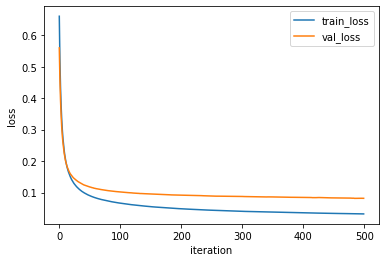

In [66]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print('32미니 배치 성능:',minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

배치 경사 하강법보다 수렴 속도가 빨라졌다.

128미니 배치 성능: 0.978021978021978


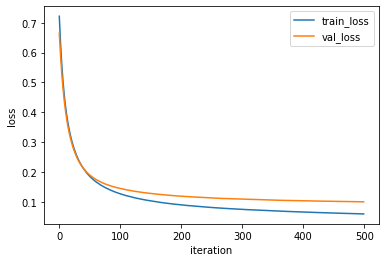

In [67]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print('128미니 배치 성능:',minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

미니 배치 크기를 늘렸더니 손실 그래프는 안정적으로 바뀌었으나 손실값이 줄어드는 속도는 느려졌다.

## 사이킷런 사용해 다층 신경망 구현
> sklearn.neural_network모듈
- 분류작업: MLPClassifier  
 - hidden_layer_sizes: 은닉층의 수와 뉴런의 수 ex)(10, )=한 개의 은닉층, 10개의 뉴런
 - activation: 은닉층의 활성화 함수. 기본값은 ReLU. 시그모이드 함수는 logistic
 - solver: 경사 하강법 알고리즘의 종류. 기본값은 확률적 경사 하강법인 sgd
 - alpha: L2규제의 양(L1규제 지원X)
 - max_iter: 에폭
- 회귀작업: MLPRegressor


In [68]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', 
                    solver='sgd', alpha=0.01, batch_size=32, 
                    learning_rate_init=0.1, max_iter=500)
mlp.fit(x_train_scaled, y_train)
print('sklearn을 이용한 다층 신경망 성능',mlp.score(x_val_scaled, y_val))

sklearn을 이용한 다층 신경망 성능 0.989010989010989
